# Downloading BBR Data

* BBR overview and how to use guide: https://confluence.sdfi.dk/pages/viewpage.action?pageId=13664878
* Metadata info: https://selfservice.datafordeler.dk/metadata/1739
* Kodelister with the mapping of the codes - https://confluence.sdfi.dk/pages/viewpage.action?pageId=195625667

In [1]:
import requests
import pandas as pd
from io import StringIO
import json
import os
from dotenv import load_dotenv

load_dotenv()

# Configuration
BASE_API = "https://services.datafordeler.dk/BBR/BBRPublic/1/REST"
USERNAME = os.getenv('BBR_USERNAME')
PASSWORD = os.getenv('BBR_PASSWORD')
method = "bygning"


Filter we will be using to get only demolition data:
* Forretningsprocess = 3 = Opdateret grundet nedrivning

Count=true to find out how many results there are

In [2]:
example_url = f"{BASE_API}/{method}?username={USERNAME}&password={PASSWORD}&status=10&count=true"
print(f"Requesting URL:\n{example_url}\n")

response = requests.get(example_url, timeout=60)
count_data = json.loads(response.text)
total_count = count_data['count']
print(f"Total count: {total_count}")

Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&status=10&count=true

Total count: 429651


Maximum number of retrieved rows is 100. We will need to use paging to retrieve all. 
The page size can be adjusted up to 999.

We can use the total count to assign the total number of pages:

In [3]:
PAGE_SIZE = 999
TOTAL_PAGES = total_count / PAGE_SIZE
TOTAL_PAGES = int(TOTAL_PAGES) + 1 if TOTAL_PAGES % 1 > 0 else int(TOTAL_PAGES)
print(f"Total pages: {TOTAL_PAGES}")

Total pages: 431


Now we can set up the loop to fetch all the results.

Running this code will take around 20 minutes.

That is why we save the results to csv file so that we can retrieve it for analysis as needed without repeating the request. 

In [4]:
PAGE = 1

df_list = []
for PAGE in range(1, TOTAL_PAGES + 1):
    print(f"Fetching page {PAGE} of {TOTAL_PAGES}...")
    url = f"{BASE_API}/{method}?username={USERNAME}&password={PASSWORD}&status=10&page={PAGE}&pagesize={PAGE_SIZE}"
    print(f"Requesting URL:\n{url}\n")
    response = requests.get(url, timeout=60)
    print(f"Status Code: {response.status_code}")
    df_temp = pd.read_json(StringIO(response.text))
    df_list.append(df_temp)

df = pd.concat(df_list, ignore_index=True)
print(f"Total records fetched: {len(df)}")
df.to_csv("data/bbr_historisk_raw.csv", index=False)

Fetching page 1 of 431...
Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&status=10&page=1&pagesize=999

Status Code: 200
Fetching page 2 of 431...
Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&status=10&page=2&pagesize=999

Status Code: 200
Fetching page 3 of 431...
Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&status=10&page=3&pagesize=999

Status Code: 200
Fetching page 4 of 431...
Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&status=10&page=4&pagesize=999

Status Code: 200
Fetching page 5 of 431...
Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&status=10&page=5&pagesize=999

Status Code: 200
Fetching page 6

# Data preparation

## Mapping values

In [5]:
import ast
import pandas as pd
import numpy as np  

The values in the raw data are stored with codes and ids instead of the values. Therefore first we need to map the values (using the provided BBRKodelister.xlsx file) to get the meaningful data.

In [6]:
df = pd.read_csv("data/bbr_historisk_raw.csv", low_memory=False)

# fix the kode list file
kode = pd.read_excel("mappings/BBRKodelister.xlsx")
kode['fields'] = kode['fields'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
kode = kode.explode('fields')
# split column fields into two columns by delimiter '.'
kode[['dataset', 'attribute']] = kode['fields'].str.split('.', expand=True)
kode = kode[['dataset',  'attribute', 'key', 'title']]
display(kode[kode['dataset']=='Bygning'].head(20))
#kode.to_csv("bbr_kodelister_processed.csv", index=False)

,dataset,attribute,key,title
56,Bygning,byg055afvigendeetager,0,Bygningen har ikke afvigende etager
57,Bygning,byg055afvigendeetager,10,Bygningen har afvigende etager
58,Bygning,byg055afvigendeetager,11,Bygningen indeholder hems
59,Bygning,byg055afvigendeetager,12,Bygningen indeholder etagegennembrydende rum
60,Bygning,byg055afvigendeetager,13,Bygningen indeholder indskudt etage
61,Bygning,byg036asbestholdigtmateriale,1,Asbestholdigt ydervægsmateriale
62,Bygning,byg036asbestholdigtmateriale,2,Asbestholdigt tagdækningsmateriale
63,Bygning,byg036asbestholdigtmateriale,3,Asbestholdigt ydervægs- og tagdækningsmateriale
64,Bygning,byg036asbestholdigtmateriale,4,Øvrige asbestholdige materialer
65,Bygning,byg036asbestholdigtmateriale,5,Ikke asbest i bygningen


The kode dataset has a list of all attributes with the key representing the id of the value and title as the actual value. 

Now we can use this to replace the values in our dataset. 

In [7]:
df['byg021BygningensAnvendelse'] = pd.to_numeric(df['byg021BygningensAnvendelse'], errors='coerce')
df['byg032YdervæggensMateriale'] = pd.to_numeric(df['byg032YdervæggensMateriale'], errors='coerce')
df['byg033Tagdækningsmateriale'] = pd.to_numeric(df['byg033Tagdækningsmateriale'], errors='coerce')
df['status'] = pd.to_numeric(df['status'], errors='coerce')
df['byg034SupplerendeYdervæggensMateriale'] = pd.to_numeric(df['byg034SupplerendeYdervæggensMateriale'], errors='coerce')
df['byg035SupplerendeTagdækningsMateriale'] = pd.to_numeric(df['byg035SupplerendeTagdækningsMateriale'], errors='coerce')



In [8]:
# for each column in df, replace the values with the corresponding title from kode where dataset and attribute match by the key, save the result to a new df

# Create a copy of the original dataframe
df_mapped = df.copy()

# Normalize the attribute column in kode to lowercase for matching
kode['attribute_lower'] = kode['attribute'].str.lower()

# For each column in df
for col in df.columns:
    # Skip non-mappable columns (like timestamps, IDs that shouldn't be mapped, etc.)
    col_lower = col.lower()
    
    # Filter kode for matching attribute
    matching_codes = kode[kode['attribute_lower'] == col_lower]
    
    if not matching_codes.empty:
        # Create a mapping dictionary from key to title
        # Convert key to numeric to match df values
        mapping_dict = {}
        for _, row in matching_codes.iterrows():
            try:
                # Handle both integer and float keys
                key_val = float(row['key']) if '.' in str(row['key']) else int(row['key'])
                mapping_dict[key_val] = row['title']
            except (ValueError, TypeError):
                # If conversion fails, use the key as-is
                mapping_dict[row['key']] = row['title']
        
        # Apply the mapping to the column
        if mapping_dict:
            df_mapped[col] = df[col].map(mapping_dict).fillna(df[col])
            #print(f"Mapped {col}: {len(mapping_dict)} codes")


In [9]:
df_mapped.head()

,datafordelerOpdateringstid,byg007Bygningsnummer,byg021BygningensAnvendelse,byg026Opførelsesår,byg037KildeTilBygningensMaterialer,byg041BebyggetAreal,byg053BygningsarealerKilde,byg094Revisionsdato,byg133KildeTilKoordinatsæt,byg134KvalitetAfKoordinatsæt,...,byg403ØvrigeBemærkningerFraStormrådet,byg132DatoForDispensationFritagelseIftKollektivVarmeforsyning,byg123MedlemskabAfSpildevandsforsyning,byg301TypeAfFlytning,byg302Tilflytterkommune,byg126TilladelseTilUdtræden,byg127DatoForTilladelseTilUdtræden,byg128TilladelseTilAlternativBortskaffelseEllerAfledning,byg129DatoForTilladelseTilAlternativBortskaffelseEllerAfledning,fordelingsarealList
0,2022-03-31T11:20:45.316286+02:00,9.0,Ukendt bygning,1000.0,Oplyst af kommunen,43.0,Maskinelt oprettet,2019-09-24T18:42:26.262279+02:00,Kommune,Sikker geokodning,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-06-30T08:48:46.996780+02:00,1.0,Fritliggende enfamiliehus,1959.0,Oplyst af ejer eller dennes repræsentant,98.0,Oplyst og kontrolleret af kommunen,2017-09-21T15:07:41.458420+02:00,Maskinelt dannet eller anden kilde,Sikker geokodning,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-08-30T10:27:53.758096+02:00,5.0,Fritliggende udestue,2001.0,Oplyst af ejer eller dennes repræsentant,14.0,Oplyst af ejer eller dennes repræsentant,2017-08-29T12:45:47.127518+02:00,Kommune,Sikker geokodning,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-09T11:21:48.188054+01:00,2.0,Carport,2007.0,Oplyst af kommunen,21.0,Oplyst af kommunen,2008-02-19T00:00:00.000000+01:00,Kommune,Sikker geokodning,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-04-02T01:23:42.388267+02:00,8.0,"(UDFASES) Bygning til hotel, restaurant, vaske...",2013.0,Oplyst af kommunen,144.0,Oplyst af kommunen,2015-01-14T14:10:06.963000+01:00,Maskinelt dannet eller anden kilde,Usikker geokodning,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Translation to English

The dataset is in Danish. We can convert the column names to English using a mapping from tabel columnames

In [10]:
columnnames = pd.read_csv("mappings/columnnames.csv")
df_mapped = df_mapped.rename(columns=columnnames.set_index('Original Field')['Translated Field'])
display(df_mapped.head(2))

,Update Time,Building Number,Building Usage,Year of Construction,Source of Building Materials,Built-up Area,Source of Building Area,Revision Date,Source of Coordinate Set,Quality of Coordinate Set,...,Other Remarks from Storm Council,Date for Dispensation/Exemption from Collective Heating Supply,Membership of Wastewater Utility,byg301TypeAfFlytning,byg302Tilflytterkommune,Permit for Withdrawal,Date for Permit for Withdrawal,Permit for Alternative Disposal or Discharge,Date for Permit for Alternative Disposal or Discharge,fordelingsarealList
0,2022-03-31T11:20:45.316286+02:00,9.0,Ukendt bygning,1000.0,Oplyst af kommunen,43.0,Maskinelt oprettet,2019-09-24T18:42:26.262279+02:00,Kommune,Sikker geokodning,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025-06-30T08:48:46.996780+02:00,1.0,Fritliggende enfamiliehus,1959.0,Oplyst af ejer eller dennes repræsentant,98.0,Oplyst og kontrolleret af kommunen,2017-09-21T15:07:41.458420+02:00,Maskinelt dannet eller anden kilde,Sikker geokodning,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Similarly, we want to translate the values of  to the Danish, and in some cases also simplify the categories for the analysis:
* "Building Usage"
* "Outer Wall Material"
* "Roof Covering Material"

In [11]:
building_usage_df = pd.read_csv("mappings/building_usage_values.csv", sep=';')

def translate_values(column, mapping_file, original_col, translated_col, delimiter=','):
    mapping_df = pd.read_csv(mapping_file, sep=delimiter)
    mapping_dict = dict(zip(mapping_df[original_col], mapping_df[translated_col]))
    return column.replace(mapping_dict)

# Define the translation mappings
translation_mappings = [
    ('Building Usage Broad', 'mappings/building_usage_values.csv', 'Original Danish', 'Suggested Group', ';'),
    ('Building Usage', 'mappings/building_usage_values.csv', 'Original Danish', 'English Translation', ';'),
    ('Outer Wall Material', 'mappings/outer_wall_material.csv', 'Danish', 'English', ','),
    ('Supplementary Outer Wall Material', 'mappings/outer_wall_material.csv', 'Danish', 'English', ','),
    ('Roof Covering Material', 'mappings/roof_covering.csv', 'Danish', 'English', ','),
    ('Supplementary Roof Covering Material', 'mappings/roof_covering.csv', 'Danish', 'English', ','),
]

# Apply translations
for column, mapping_file, original_col, translated_col, delimiter in translation_mappings:
    if column == 'Building Usage Broad':
        # Create new column based on Building Usage
        df_mapped[column] = translate_values(df_mapped['Building Usage'], mapping_file, original_col, translated_col, delimiter)
    else:
        df_mapped[column] = translate_values(df_mapped[column], mapping_file, original_col, translated_col, delimiter)

## New/modified columns
### Coordinates conversion

In [12]:
from pyproj import Transformer

# Define transformer: UTM Zone 32N (EPSG:32632) → WGS84 (EPSG:4326)
transformer = Transformer.from_crs("EPSG:25832", "EPSG:4326", always_xy=True)


# Extract coordinates from POINT format and convert from UTM to WGS84
def convert_coordinate(coord_str):
    if pd.isna(coord_str):
        return None
    try:
        # Extract x, y from "POINT(x y)" format
        coords = coord_str.replace('POINT(', '').replace(')', '').split()
        x, y = float(coords[0]), float(coords[1])
        # Transform to WGS84 (returns lon, lat)
        lon, lat = transformer.transform(x, y)
        return f"{lat} {lon}"
    except:
        return None

df_mapped['Coordinate Converted'] = df_mapped['Coordinate'].apply(convert_coordinate)
df_mapped['lat'] = df_mapped['Coordinate Converted'].apply(lambda x: x.split()[0] if x else None)
df_mapped['lon'] = df_mapped['Coordinate Converted'].apply(lambda x: x.split()[1] if x else None)


### demolition year

In [13]:
df_mapped['Demolition Year'] = df_mapped['Effect From'].str[:4].astype(int)

### Building age at demolition

In [14]:
# ignore year 1000 as it's likely a placeholder/invalid value

df_mapped['Building Age at Demolition'] = df_mapped.apply(
    lambda row: np.nan if pd.isna(row['Year of Construction']) or row['Year of Construction'] == 1000 
    else float(row['Demolition Year']) - float(row['Year of Construction']), 
    axis=1
)

### Area

In [15]:
# Areas should be positive values
df_mapped['Built-up Area'] = pd.to_numeric(df_mapped['Built-up Area'], errors='coerce').abs()
df_mapped['Total Building Area'] = pd.to_numeric(df_mapped['Total Building Area'], errors='coerce').abs()
df_mapped['Total Commercial Area'] = pd.to_numeric(df_mapped['Total Commercial Area'], errors='coerce').abs()
df_mapped['Total Residential Area'] = pd.to_numeric(df_mapped['Total Residential Area'], errors='coerce').abs()

# new column Area that takes whatever value is bigger between 'Built-up Area' and 'Total Building Area'
df_mapped['Area'] = df_mapped[['Built-up Area', 'Total Building Area', 'Total Commercial Area', 'Total Residential Area']].max(axis=1)

# Data Visualization

First let's create a simple pivot table looking at buldings of area > 200 m2 summarizing 
* the number of demolished  buildings
* total Built-up area
* total Building area

per Building Usage kind and per year

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

## Filtering the dataset
* Area more than 500 m2
* not Errorneously Registered

In [17]:
print(f'Total number of records in the dataset: {len(df_mapped)}')

Total number of records in the dataset: 429651


In [18]:
df_filtered = df_mapped[df_mapped['Area']>=500].copy()

print(f'# of records after filtering by area: \t\t{len(df_filtered)}')

df_filtered = df_filtered[df_filtered['Status']!='Fejlregistreret']

print(f'# of records after filtering by status: \t{len(df_filtered)}')

# of records after filtering by area: 		17444
# of records after filtering by status: 	17444


## Dataset characteristicts

In [19]:
## Dataset characteristics

pd.set_option('display.max_columns', None)
df_filtered.describe(include='all')

,Update Time,Building Number,Building Usage,Year of Construction,Source of Building Materials,Built-up Area,Source of Building Area,Revision Date,Source of Coordinate Set,Quality of Coordinate Set,Location on Territorial Waters,Coordinate,Coordinate System,Business Event,Business Area,Business Process,Plot,House Number,Local ID,Namespace,Parcel,Municipality Code,Registration From,Registration Actor,Status,Effect From,Effect Actor,Floor List,Entrance List,Outer Wall Material,Roof Covering Material,Total Building Area,Total Residential Area,Number of Floors,Heating Installation,Heating Medium,Supplementary Heating,Supplementary Information on Coordinate Set,Total Commercial Area,Year of Extension,Building on Foreign Land List,Area of Covered Area,Preservation,Validity Date,Water Supply,Drainage Conditions,Area of Built-in Shed,Date for Temporary Building,Flood Risk Self-Insurance (Storm Council),Date of Registration from Storm Council,Area of Built-in Conservatory or Similar,Area of Built-in Garage,Deviating Floors,Discharge Permit,Area of Waste Room at Ground Level,Building Damage Insurance Company,Covered by Building Damage Insurance,Shelter Room Spaces,Access Area,Date for Building Damage Insurance,Asbestos-containing Material,Supplementary Outer Wall Material,Supplementary Roof Covering Material,Other Area,Servitude for Rental Property Date,Area of Built-in Carport,Condominium,Area of External Insulation,Total Area of Closed Covers on Building,Dispensation/Exemption from Collective Heating Supply,Order Regarding Wastewater Disposal,Deadline Regarding Wastewater Disposal,Other Remarks from Storm Council,Date for Dispensation/Exemption from Collective Heating Supply,Membership of Wastewater Utility,byg301TypeAfFlytning,byg302Tilflytterkommune,Permit for Withdrawal,Date for Permit for Withdrawal,Permit for Alternative Disposal or Discharge,Date for Permit for Alternative Disposal or Discharge,fordelingsarealList,Building Usage Broad,Coordinate Converted,lat,lon,Demolition Year,Building Age at Demolition,Area
count,17444,17444.000000,17444,17432.000000,17441,17441.000000,17441,13408,12694,12697,17197,13424,13424,17444,17444,17444,17444,16762,17444,17444,1.698100e+04,17444,17444,17444,17444,17444,17444,12025,10189,17325,17444,16950.000000,1405.000000,16969.000000,17143.000000,4414,4154,11325,16166.000000,4772.000000,235,564.000000,36,685,1291,1353,85.000000,186,19,19,70.000000,49.000000,1656,58,18.000000,183,176,918.000000,104.000000,52,32,17442,17444,289.000000,20,23.000000,6,4.000000,18.000000,0,0,0,1,0,0,1.0,1.0,0,0,0,0,3,17444,13424,13424,13424,17444.000000,17415.000000,17444.000000
unique,17444,NaN,96,NaN,6,NaN,5,10662,4,3,2,13116,1,1,1,11,11780,11975,17444,1,NaN,98,9134,1,1,15982,7,12025,10189,12,14,NaN,NaN,NaN,NaN,7,9,6,NaN,NaN,172,NaN,7,159,7,36,NaN,148,2,5,NaN,NaN,5,4,NaN,11,4,NaN,NaN,36,2,11,12,NaN,6,NaN,6,NaN,NaN,0,0,0,1,0,0,NaN,NaN,0,0,0,0,3,10,13116,13116,13116,NaN,NaN,NaN
top,2021-12-15T15:31:16.044272+01:00,NaN,(Phased out) Building for commercial productio...,NaN,Oplyst af kommunen,NaN,Oplyst af kommunen,2017-01-04T19:18:42.143000+01:00,Kommune,Sikker geokodning,Ikke på søterritorie,POINT(722328.27 6195874.94),UTM 32 Euref89,Bygning,54.15.05.05,Ikke angivet,e5a76cca-015b-4f98-96f7-12a02bf40ea2,0a3f508d-a88a-32b8-e044-0003ba298018,0000ce19-e849-4a03-b0cf-bad06ba5ae9b,http://data.gov.dk/bbr/bygning,NaN,Københavns Kommune,2017-06-02T14:29:37.000000+02:00,BBR,Historisk,2017-06-02T14:29:37.000000+02:00,Registerfører,[{'id_lokalId': '14f91322-1c48-4999-a135-72bc0...,[{'id_lokalId': '2565d11c-ed33-4573-8941-37e0e...,Brick,Fiber cement including asbestos,NaN,NaN,NaN,NaN,Flydende brændsel,(UDFASES) Bygningen har ingen supplerende varme,Koordinatsæt ligger på matriklen,NaN,NaN,[{'id_lokalId': 'c38ca285-945d-4cf1-b5d5-c151c...,NaN,"Bygningen medtaget i registrant, bevaringsplan...",2018-09-10T00:00:00.000000+02:00,Alment vandforsyningsanlæg,Afløb til offentligt kloaksystem,NaN,2015-08-31T00:00:00.000000+02:00,Ingen udbetalt 

### Building characteristics 

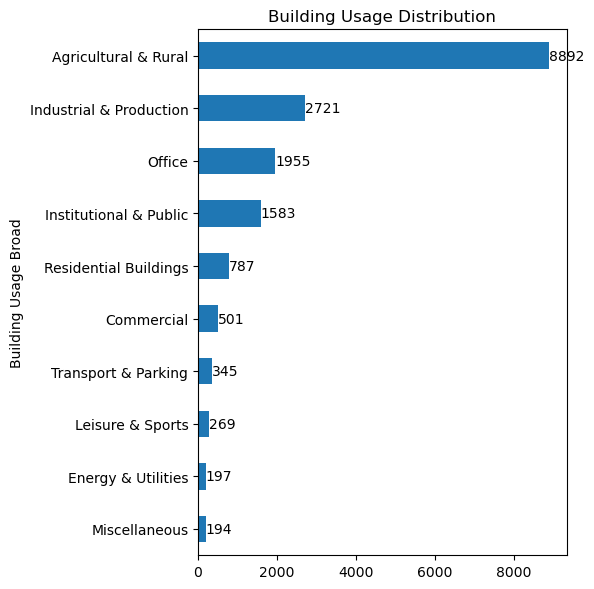

In [20]:
ax = df_filtered['Building Usage Broad'].value_counts().plot(kind='barh', 
                                                       figsize=(6,6), 
                                                       title='Building Usage Distribution')
ax.bar_label(ax.containers[0])
# descending
ax.invert_yaxis()
plt.tight_layout()
plt.show()

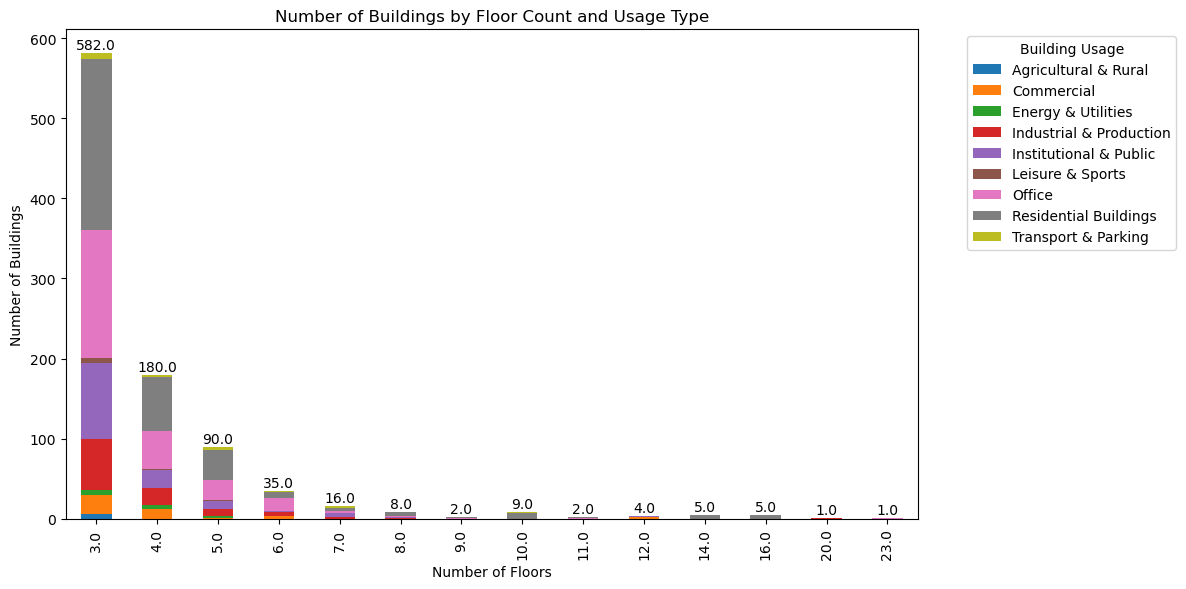

In [21]:
df_higher_than_3_floors = df_filtered[df_filtered['Number of Floors'] >= 3].copy()
ax = df_higher_than_3_floors.groupby(['Number of Floors', 'Building Usage Broad']).size().unstack().plot(kind='bar', 
                                                                                            stacked=True,
                                                                                            figsize=(12,6), 
                                                                                            title='Number of Buildings by Floor Count and Usage Type')
ax.set_xlabel('Number of Floors')
ax.set_ylabel('Number of Buildings')
ax.legend(title='Building Usage', bbox_to_anchor=(1.05, 1), loc='upper left')
# show data labels
# sum the heights of each stack to get total height for each bar
totals = df_higher_than_3_floors.groupby(['Number of Floors', 'Building Usage Broad']).size().unstack().sum(axis=1)
for i, total in enumerate(totals):
    ax.text(i, total + 5, str(total), ha='center')
plt.tight_layout()
plt.show()

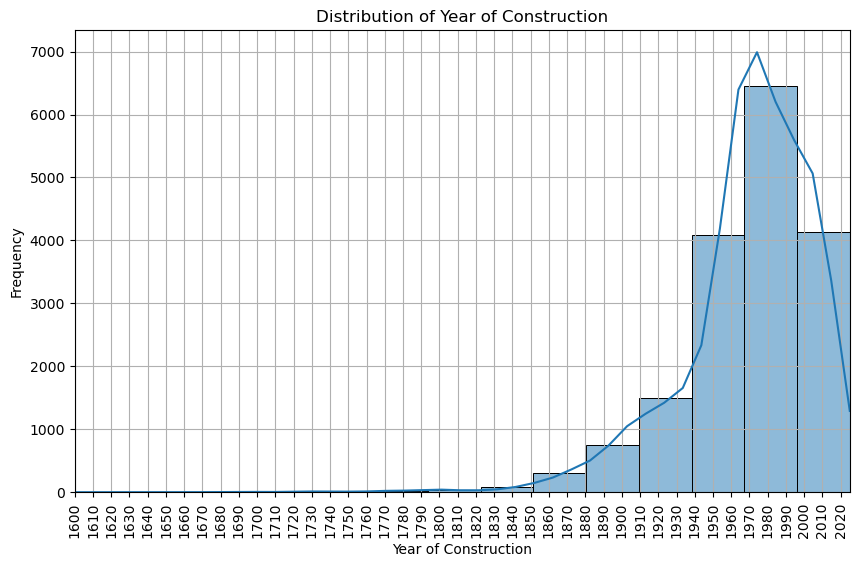

In [22]:
# plot the distribution of building age at demolition 
# zoom in to age between 0 and 150 years
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['Year of Construction'], bins=70, kde=True)
plt.title('Distribution of Year of Construction')
plt.xlabel('Year of Construction')
plt.ylabel('Frequency')
plt.xlim(1600, 2025)
# show all ticks on x axis vertically
plt.xticks(np.arange(1600, 2026, 10), rotation=90)
plt.grid()
plt.show()

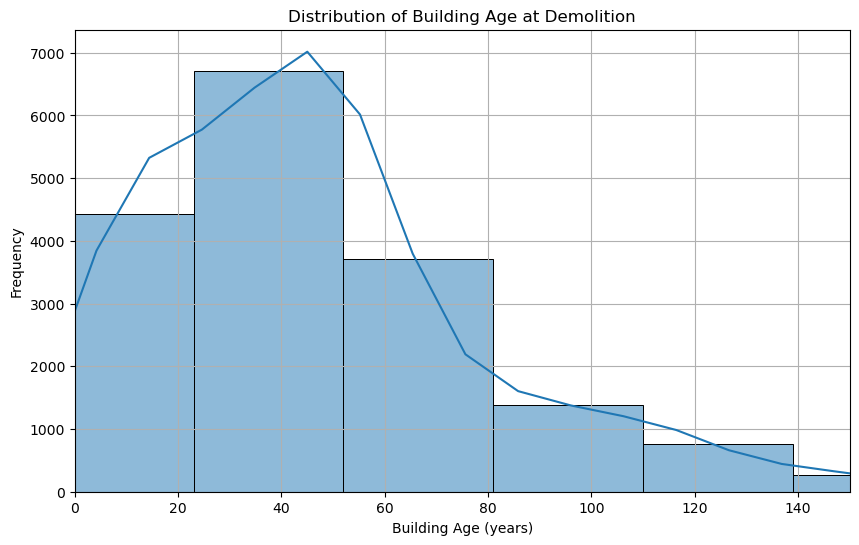

In [23]:
# plot the distribution of building age at demolition 
# zoom in to age between 0 and 150 years
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['Building Age at Demolition'], bins=70, kde=True)
plt.title('Distribution of Building Age at Demolition')
plt.xlabel('Building Age (years)')
plt.ylabel('Frequency')
plt.xlim(0, 150)
plt.grid()
plt.show()

In [24]:
df_mapped['Effect From'] = df_mapped['Effect From'].str[:4]
df_group = df_mapped.groupby(['Building Usage Broad', 'Effect From']).agg({
    'Building Number': 'count',
    'Built-up Area': ['sum', 'count'],
    'Total Building Area': ['sum', 'count'],
    'Total Commercial Area': ['sum', 'count'],
    'Total Residential Area': ['sum', 'count']
})
df_group.columns = ['Number of Buildings', 'Total Built-up Area', 'Count of Built-up Area', 'Total Building Area', 'Count of Building Area', 'Total Commercial Area', 'Count of Commercial Area', 'Total Residential Area', 'Count of Residential Area']
display(df_group)

Number of Buildings  Total Built-up Area  \
Building Usage Broad Effect From                                             
Agricultural & Rural 2000                       11454            1446737.0   
                     2001                         139              18099.0   
                     2002                         110              15513.0   
                     2003                         152              20609.0   
                     2004                         165              21689.0   
...                                               ...                  ...   
Transport & Parking  2021                        5898             190904.0   
                     2022                        7171             251880.0   
                     2023                        8578             268752.0   
                     2024                        6537             217967.0   
                     2025                        9685             306645.0   

                                  Count of Built-up Area  Total Building Area  \
Building Usage Broad Effect From                                                
Agricultural & Rural 2000                          11408            1242470.0   
                     2001                            139              15368.0   
                     2002                            109              12750.0   
                     2003                            151              17050.0   
                     2004                            164              17224.0   
...                                                  ...                  ...   
Transport & Parking  2021                           5891              25366.0   
                     2022                           7163              54423.0   
                     2023                           8570              51765.0   
                     2024                           6525              34136.0   
                     2025                           9654              53748.0   

                                  Count of Building Area  \
Building Usage Broad Effect From                           
Agricultural & Rural 2000                           5711   
                     2001                             54   
                     2002                             52   
                     2003                             68   
                     2004                             73   
...                                                  ...   
Transport & Parking  2021                            107   
                     2022                            195   
                     2023                            174   
                     2024                            128   
                     2025                            157   

                                  Total Commercial Area  \
Building Usage Broad Effect From                          
Agricultural & Rural 2000                     1223821.0   
                     2001                       14922.0   
                     2002                       11878.0   
                     2003                       16031.0   
                     2004                       17268.0   
...                                                 ...   
Transport & Parking  2021                       25417.0   
                     2022                       56239.0   
                     2023                       57254.0   
                     2024                       34876.0   
                     2025                       88766.0   

                                  Count of Commercial Area  \
Building Usage Broad Effect From                             
Agricultural & Rural 2000                             5153   
                     2001                               48   
                     2002                               46   
                     2003                               57   
                     2004                   

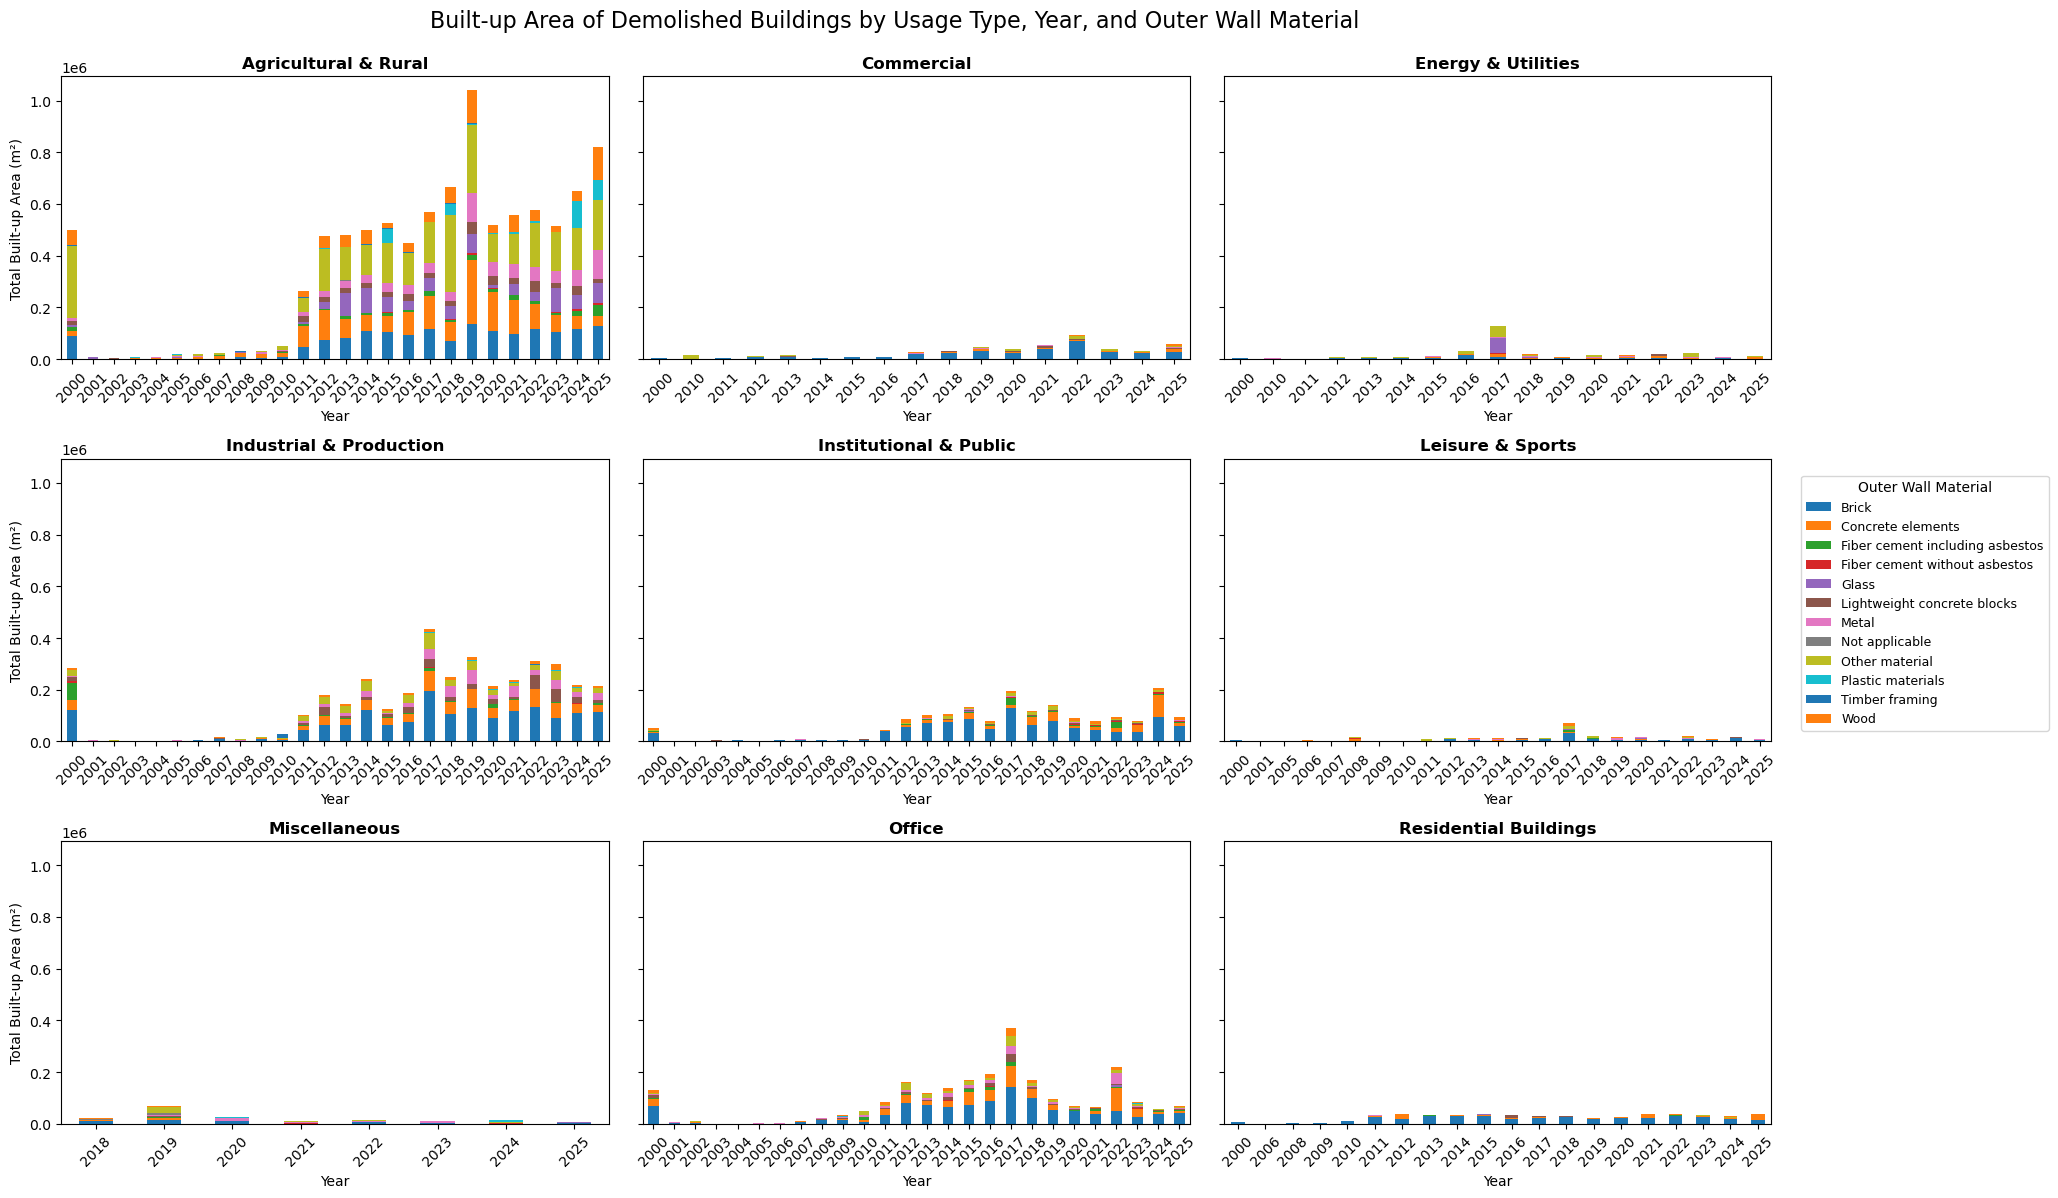

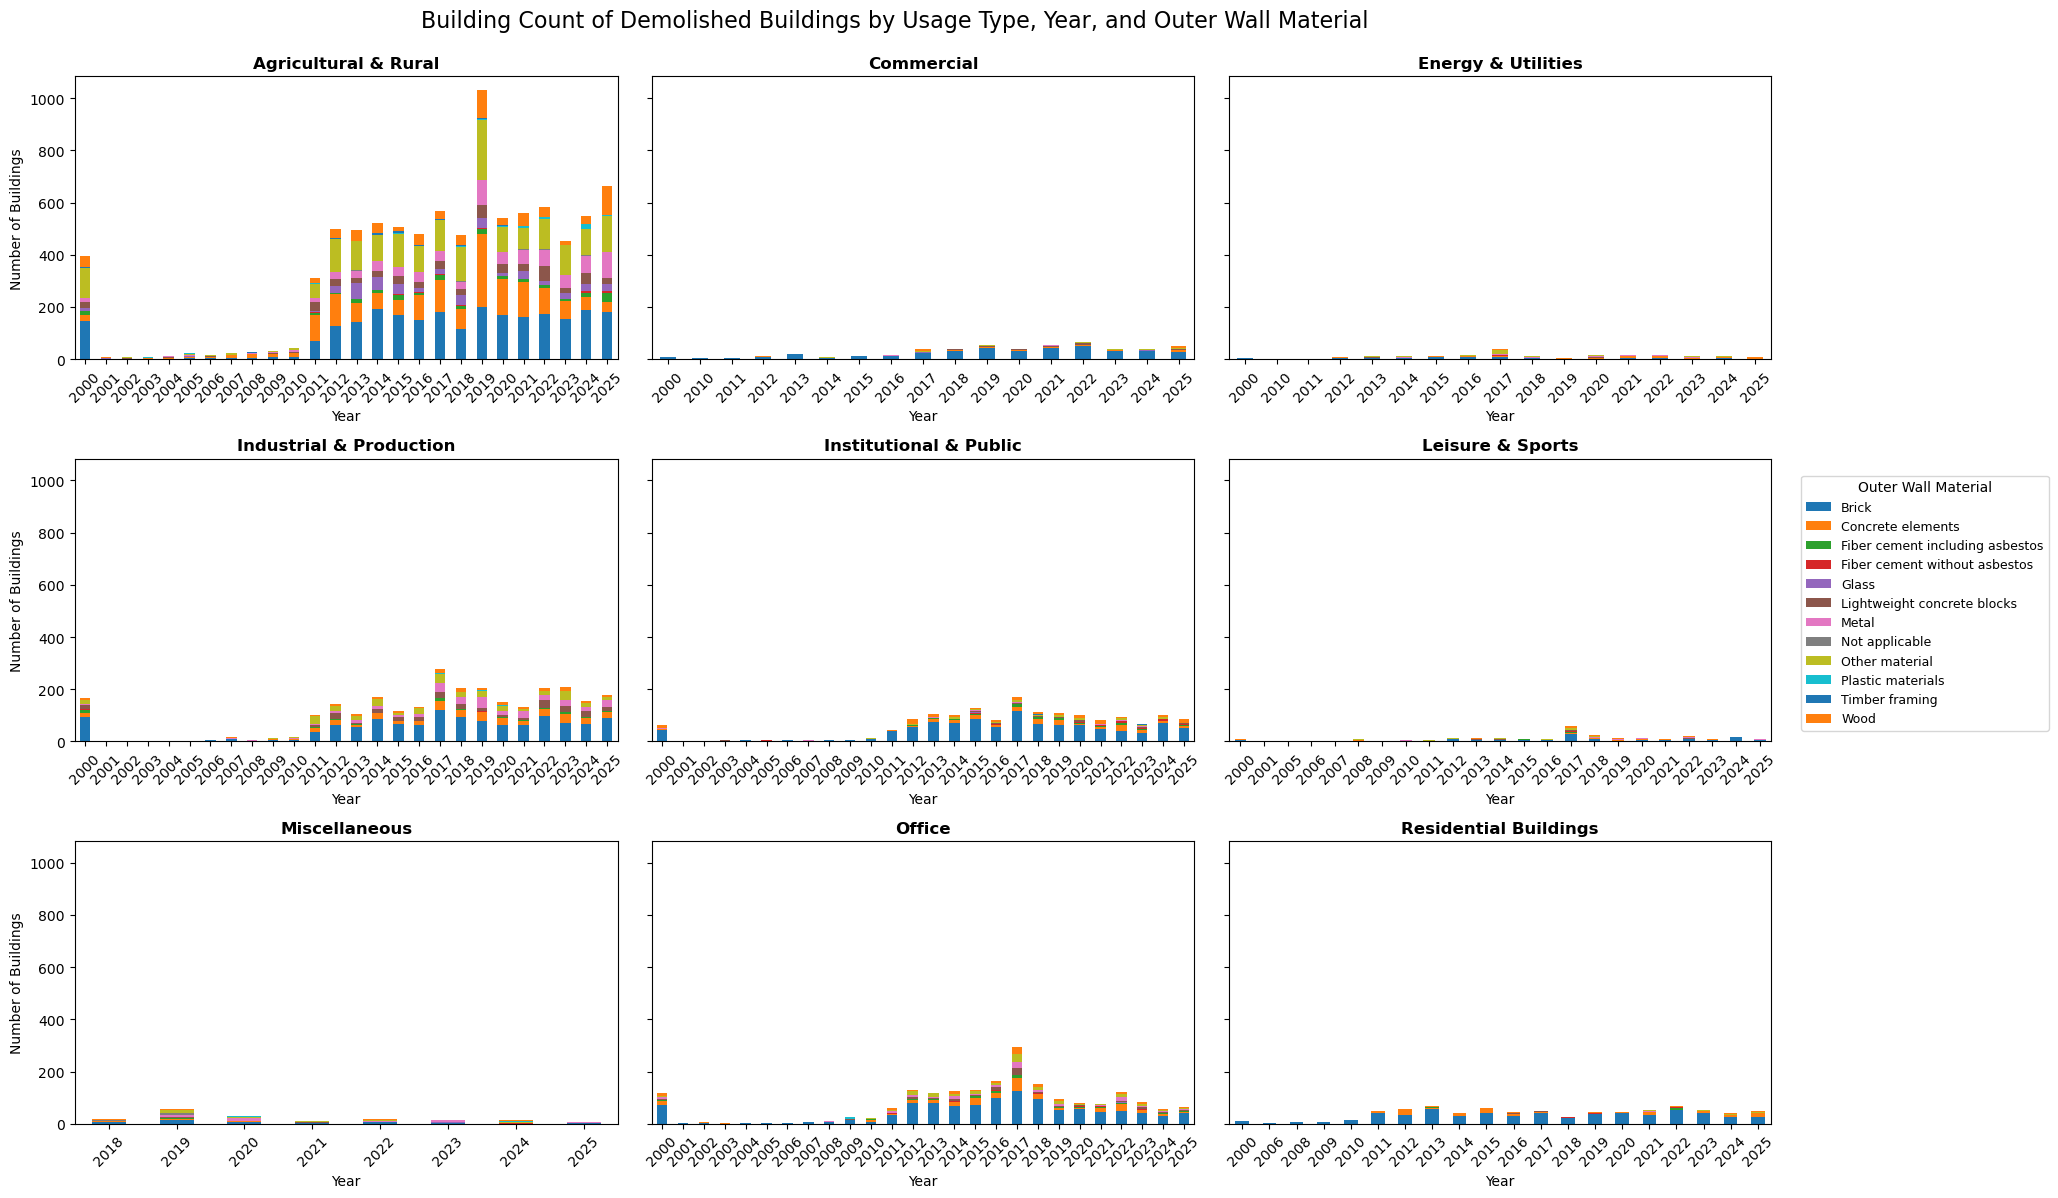

In [25]:
def plot_stacked_area_by_material(df, material_column, title_suffix, plot_type='sum'):
    """
    Create a stacked bar plot showing total built-up area or count by building usage, year, and material type.
    
    Parameters:
    df: DataFrame - The main dataframe (will be copied)
    material_column: str - Column name for the material ('Outer Wall Material' or 'Roof Covering Material')
    title_suffix: str - Suffix for the plot title (e.g., 'Wall Material' or 'Roof Covering Material')
    plot_type: str - Either 'sum' for total built-up area or 'count' for number of buildings (default: 'sum')
    """
    # Prepare data for plotting
    df_plot = df.copy()
    df_plot['Effect From'] = df_plot['Effect From'].str[:4]
    
    # Remove any rows with missing values in the columns we need
    required_columns = ['Building Usage Broad', 'Effect From', material_column]
    if plot_type == 'sum':
        required_columns.append('Built-up Area')
    df_plot = df_plot.dropna(subset=required_columns)
    
    # Exclude year 2017
    #df_plot = df_plot[df_plot['Registration From'] != '2017']
    
    # Aggregate by Building Usage, Effect From, and Material
    if plot_type == 'sum':
        df_plot_grouped = df_plot.groupby(['Building Usage Broad', 'Effect From', material_column])['Built-up Area'].sum().reset_index(name='value')
        y_label = 'Total Built-up Area (m²)'
        metric_name = 'Built-up Area'
    else:  # count
        df_plot_grouped = df_plot.groupby(['Building Usage Broad', 'Effect From', material_column]).size().reset_index(name='value')
        y_label = 'Number of Buildings'
        metric_name = 'Building Count'
    
    # Create a pivot table for stacked bars
    df_pivot = df_plot_grouped.pivot_table(
        index=['Building Usage Broad', 'Effect From'], 
        columns=material_column, 
        values='value', 
        fill_value=0
    ).reset_index()
    
    # Get unique building usages and years
    building_usages = sorted(df_pivot['Building Usage Broad'].unique())
    
    # Get all materials for consistent coloring
    materials = [col for col in df_pivot.columns if col not in ['Building Usage Broad', 'Effect From']]
    
    # Create subplots
    fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=False, sharey=True)
    axes = axes.flatten()
    
    for idx, usage in enumerate(building_usages):
        if idx >= len(axes):
            break
        
        ax = axes[idx]
        usage_data = df_pivot[df_pivot['Building Usage Broad'] == usage].set_index('Effect From')[materials]

        # Create stacked bar plot
        usage_data.plot(kind='bar', stacked=True, ax=ax, legend=False)
        
        ax.set_title(f'{usage}', fontsize=12, fontweight='bold')
        ax.set_xlabel('Year')
        ax.set_ylabel(y_label)
        ax.tick_params(axis='x', rotation=45)
    
    # Remove empty subplots
    for idx in range(len(building_usages), len(axes)):
        fig.delaxes(axes[idx])
    
    # Add legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title=material_column, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
    
    fig.suptitle(f'{metric_name} of Demolished Buildings by Usage Type, Year, and {title_suffix}', fontsize=16, y=0.995)
    plt.tight_layout()
    plt.show()

# Plot for Roof Covering Material - sum of built-up area
plot_stacked_area_by_material(df_filtered, 'Outer Wall Material', 'Outer Wall Material', plot_type='sum')

# Plot for Roof Covering Material - count of buildings
plot_stacked_area_by_material(df_filtered, 'Outer Wall Material', 'Outer Wall Material', plot_type='count')


## Age

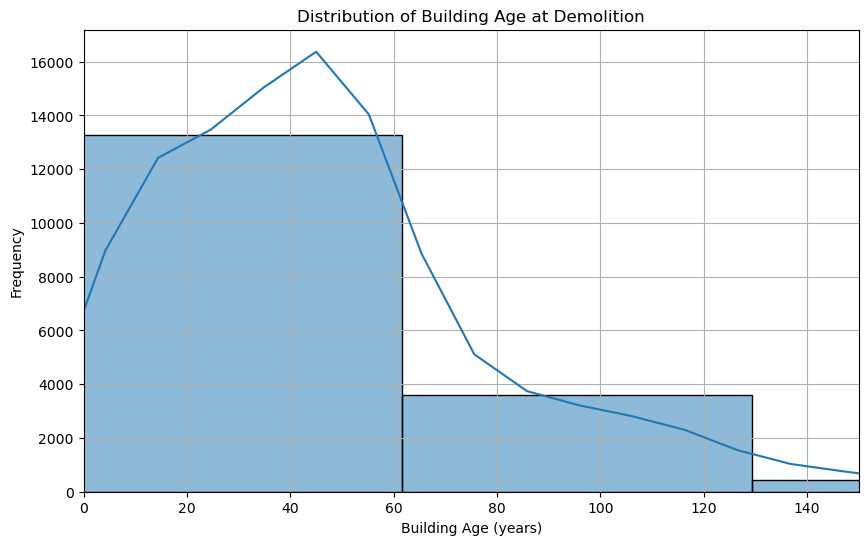

In [26]:
# plot the distribution of building age at demolition 
# zoom in to age between 0 and 150 years
plt.figure(figsize=(10, 6))
sns.histplot(df_filtered['Building Age at Demolition'], bins=30, kde=True)
plt.title('Distribution of Building Age at Demolition')
plt.xlabel('Building Age (years)')
plt.ylabel('Frequency')
plt.xlim(0, 150)
plt.grid()
plt.show()

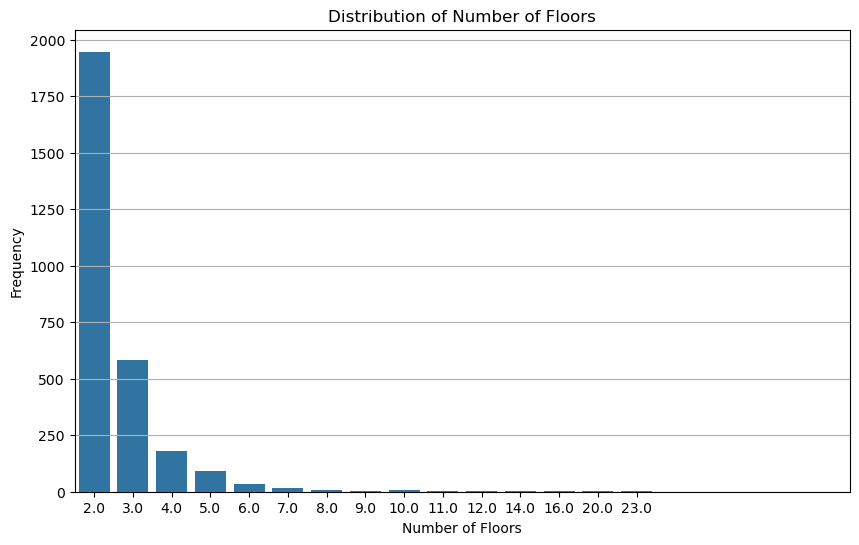

In [27]:
# plot the distribution of number of floors
# only positive values of number of floors

plt.figure(figsize=(10, 6))
sns.barplot(x=df_filtered[df_filtered['Number of Floors'] > 1]['Number of Floors'].value_counts().sort_index().index,
            y=df_filtered[df_filtered['Number of Floors'] > 1]['Number of Floors'].value_counts().sort_index().values)
plt.title('Distribution of Number of Floors')
plt.xlabel('Number of Floors')
plt.ylabel('Frequency')
plt.xlim(-0.5, 19.5)
plt.grid(axis='y')
plt.show()

# Interactive map of the demolished buildings in Denmark

In [28]:
import folium 

denmark_map = folium.Map(location=[55.6761, 12.5683], zoom_start=10)

# Filter out rows without coordinates
df_filtered_with_data = df_filtered.dropna(subset=['Coordinate Converted'])

# Function to determine marker color based on Building Usage Broad
def get_marker_color(row):
    
    # Color mapping for different building usage types
    usage_colors = {
        'Residential Buildings': '#e74c3c',        # Red
        'Commercial': '#3498db',                   # Blue
        'Industrial & Production': '#95a5a6',      # Gray
        'Agricultural & Rural': '#27ae60',         # Green
        'Institutional & Public': '#f39c12',       # Orange
        'Office': '#9b59b6',                       # Purple
        'Transport & Parking': '#0f3885',          # Dark Blue
        'Leisure & Sports': '#e67e22'              # Dark orange
    }
    
    # Get the building usage broad category
    usage = row.get('Building Usage Broad')
    
    # Return the corresponding color or default to gray
    return usage_colors.get(usage, '#7f8c8d')  # Default gray

# Function to normalize usage names for CSS class names
def normalize_usage_name(usage):
    """Convert usage name to CSS-friendly format by replacing spaces and special chars with hyphens"""
    if pd.isna(usage) or usage == 'Unknown':
        return 'unknown'
    # Replace spaces and '&' with hyphens, convert to lowercase
    return usage.replace(' ', '-').replace('&', 'and').lower()

# Get min and max values for sliders
min_floors = int(df_filtered_with_data['Number of Floors'].min())
max_floors = int(df_filtered_with_data['Number of Floors'].max())
min_area = int(df_filtered_with_data['Area'].min())
max_area = int(df_filtered_with_data['Area'].max())
min_age = int(df_filtered_with_data['Building Age at Demolition'].min())
max_age = int(df_filtered_with_data['Building Age at Demolition'].max())

# Load popup template
with open('popup_template.html', 'r') as f:
    popup_template = f.read()

# Add markers with floor, area, age, and usage data attributes for filtering
for _, row in df_filtered_with_data.iterrows():
    coords = row['Coordinate Converted'].split()
    lat, lon = float(coords[0]), float(coords[1])
    color = get_marker_color(row)
    
    # Determine radius based on built-up area with better scaling for large buildings
    area = row.get('Area', 500)
    # Use square root scaling for better visual distinction across wide range
    radius = min(max(np.sqrt(area) / 5, 3), 30)  # Scale with sqrt, range 3-30
    
    floors = row.get('Number of Floors', 0)
    age = row.get('Building Age at Demolition', 0)
    usage_broad = row.get('Building Usage Broad', 'Unknown')
    
    # Create popup text from template
    popup_text = popup_template.format(
        area=f"{area:.0f}",
        total_building_area=f"{row.get('Total Building Area', 0):.0f}",
        floors=f"{floors:.0f}",
        usage_broad=usage_broad if usage_broad != 'Unknown' else 'N/A',
        usage=row.get('Building Usage', 'N/A'),
        municipality=row.get('Municipality Name', 'N/A'),
        status=row.get('Status', 'N/A'),
        construction_year=f"{row.get('Year of Construction', 'N/A'):.0f}",
        extension_year=f"{row.get('Year of Extension', 'N/A'):.0f}",
        demolition_year=row.get('Demolition Year', 'N/A'),
        age_at_demolition=f"{row.get('Building Age at Demolition', 'N/A'):.0f}",
        outer_wall='' if row.get('Outer Wall Material', '') == 'Not applicable' else row.get('Outer Wall Material', ''),
        supp_outer_wall='' if row.get('Supplementary Outer Wall Material') == 'Not applicable' else row.get('Supplementary Outer Wall Material', ''),
        roof_covering='' if row.get('Roof Covering Material') == 'Not applicable' else row.get('Roof Covering Material', ''),
        supp_roof_covering='' if row.get('Supplementary Roof Covering Material') == 'Not applicable' else row.get('Supplementary Roof Covering Material', ''),
        lat=lat,
        lon=lon
    )
    
    # Create marker with custom class including usage type for checkbox filtering
    marker = folium.CircleMarker(
        location=[lat, lon],
        radius=radius,
        popup=popup_text,
        color=color,
        fill=True,
        fillColor=color,
        fillOpacity=0.7
    )
    # Add custom class with floor number, area, age, and normalized usage for filtering
    usage_class = normalize_usage_name(usage_broad)
    marker.options['className'] = f'building-marker floor-{int(floors) if not pd.isna(floors) else 0} area-{int(area)} age-{int(age) if not pd.isna(age) else 0} usage-{usage_class}'
    marker.add_to(denmark_map)

# Load map controls and legend from external file
with open('map_controls.html', 'r') as f:
    map_html = f.read()

# Replace placeholders with actual values
map_html = map_html.replace('{min_floors}', str(min_floors))
map_html = map_html.replace('{max_floors}', str(max_floors))
map_html = map_html.replace('{min_area}', str(min_area))
map_html = map_html.replace('{max_area}', str(max_area))
map_html = map_html.replace('{min_age}', str(min_age))
map_html = map_html.replace('{max_age}', str(max_age))

denmark_map.get_root().html.add_child(folium.Element(map_html))

# Save the initial map
denmark_map.save("nedrivning_map.html")

# Add custom title and favicon to the HTML
with open('nedrivning_map.html', 'r', encoding='utf-8') as f:
    html_content = f.read()

# Define custom title and favicon
custom_title = "Denmark Demolished Buildings Map"
# Using a building/construction emoji as favicon (data URI)
# You can replace this with a link to your own .ico or .png file
favicon_html = '''<link rel="icon" href="data:image/svg+xml,<svg xmlns=%22http://www.w3.org/2000/svg%22 viewBox=%220 0 100 100%22><text y=%22.9em%22 font-size=%2290%22>🏗️</text></svg>">'''

# Insert title and favicon in the <head> section
if '<head>' in html_content:
    html_content = html_content.replace(
        '<head>',
        f'<head>\n    <title>{custom_title}</title>\n    {favicon_html}',
        1  # Only replace the first occurrence
    )

# Save the modified HTML
with open('nedrivning_map2.html', 'w', encoding='utf-8') as f:
    f.write(html_content)

print(f"Map saved with custom title: '{custom_title}'")


Map saved with custom title: 'Denmark Demolished Buildings Map'


# All Building Data on the Demolished location

In [ ]:
import requests
import pandas as pd
from io import StringIO
import json
import ast 
import os

# Configuration
BASE_API = "https://services.datafordeler.dk/BBR/BBRPublic/1/REST"
USERNAME = os.getenv('BBR_USERNAME')
PASSWORD = os.getenv('BBR_PASSWORD')
method = "bygning"

import concurrent.futures

cases = []
plots = df_filtered["Plot"].unique()
total_count = len(plots)

def fetch_case(index_grund):
    index, grund = index_grund
    example_url = f"{BASE_API}/{method}?username={USERNAME}&password={PASSWORD}&Grund={grund}"
    print(f"index {index} of {total_count} Requesting URL:\n{example_url}\n")
    try:
        response = requests.get(example_url, timeout=60)
        if response.status_code == 200:
            return response.text
        else:
            print(f"Error fetching data for Plot {grund}: Status Code {response.status_code}")
            return None
    except Exception as e:
        print(f"Exception for Plot {grund}: {e}")
        return None

with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(fetch_case, enumerate(plots)))

cases = [r for r in results if r is not None]


index 0 of 11780 Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&Grund=cbc174fb-724d-4af7-a379-2e33fc0c54af

index 1 of 11780 Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&Grund=29323a24-0c71-4e43-a666-6320e750ad87

index 2 of 11780 Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&Grund=f9e48a84-adeb-4962-a176-6c6eac0c689b

index 3 of 11780 Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&Grund=23f89dbf-e626-4439-be5d-97bf2c00b319

index 4 of 11780 Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/1/REST/bygning?username=RXONEKMVZY&password=cumacek0925BBR.&Grund=555dc231-b50c-47b2-bb95-dd9a95ae3062

index 5 of 11780 Requesting URL:
https://services.datafordeler.dk/BBR/BBRPublic/

In [10]:
df_cases = pd.DataFrame()
for case in cases:
    df_temp = pd.read_json(StringIO(case))
    df_cases = pd.concat([df_cases, df_temp], ignore_index=True)

df_cases.head()

,datafordelerOpdateringstid,byg007Bygningsnummer,byg021BygningensAnvendelse,byg026Opførelsesår,byg032YdervæggensMateriale,byg033Tagdækningsmateriale,byg037KildeTilBygningensMaterialer,byg041BebyggetAreal,byg053BygningsarealerKilde,byg094Revisionsdato,...,byg125FristVedrSpildevandsafledning,byg036AsbestholdigtMateriale,byg029DatoForMidlertidigOpførtBygning,byg140ServitutForUdlejningsEjendomDato,byg046SamletArealAfLukkedeOverdækningerPåBygningen,byg130ArealAfUdvendigEfterisolering,byg111StormrådetsOversvømmelsesSelvrisiko,byg112DatoForRegistreringFraStormrådet,ejerlejlighed,byg123MedlemskabAfSpildevandsforsyning
0,2021-04-03T01:51:56.162102+02:00,7.0,930.0,2009.0,5.0,5.0,5.0,40.0,5.0,2019-11-13T14:50:48.316647+01:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-10T10:07:29.584809+02:00,6.0,421.0,2007.0,5.0,6.0,2.0,162.0,2.0,2019-11-13T14:50:46.514254+01:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-02T22:53:40.236402+02:00,21.0,930.0,2010.0,5.0,2.0,5.0,48.0,5.0,2018-06-07T21:43:38.481689+02:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-04-01T23:26:56.095839+02:00,10.0,160.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-09-10T10:09:28.928671+02:00,14.0,441.0,1988.0,1.0,5.0,2.0,531.0,2.0,2019-11-13T14:50:47.863497+01:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
len(df_cases)

5061

In [ ]:
df_cases.to_csv("data/bbr_nedrivning_bygning_all.csv", index=False)